This notebook fits SleepNet on simulated images with PSF stars and Gaussian galaxies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import torch
from torch import optim

from bliss.models import encoder
from bliss.datasets import sdss

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, './utils/')
import source_simulator_lib
import dataset_lib
import catalog_optimizer_lib

import plotting_utils 
from which_device import device

In [4]:
torch.random.manual_seed(23424)

In [5]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

catalog_file = '../sdss_galaxies/coadd_field_catalog_runjing_liu.fit'

# Load PSF

In [6]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

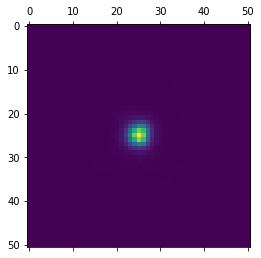

In [7]:
%matplotlib inline

plt.matshow(psf)

# The encoder

In [8]:
from bliss.sleep import SleepPhase

In [9]:
slen = 100
max_detections = 2
n_bands = 1
tile_slen = 10
ptile_slen = 50


encoder_kwargs = dict(max_detections = max_detections,
                      n_bands = 1,
                      tile_slen = tile_slen,
                      ptile_slen = ptile_slen)

# doesn't matter -- we will use our own decoder. 
# just set it up so the init works
decoder_kwargs = dict(max_sources = 2,
                      slen = slen,
                      ptile_slen = ptile_slen, 
                      tile_slen = tile_slen, 
                      psf_params_file = '../../data/fitted_powerlaw_psf_params.npy')

In [10]:
sleep_net = SleepPhase(encoder_kwargs = encoder_kwargs, 
                       decoder_kwargs = decoder_kwargs).to(device)

# The dataset

The data is sampled with PSF stars and Gaussian galaxies. 

Stars are parameterized by location and flux. 

Gaussian galaxies are parameterized by location, flux, ellipticity, rotation, and half-light radius. 

All parameters are drawn uniformly from a pre-specified range (see default arguments to `dataset_lib.SimulatedImages`). 

The probability of a star or galaxy is 50/50. 

In [11]:
background = 862

In [12]:
_psf = torch.Tensor([psf]).to(device)

In [13]:
batchsize = 10
border_padding = sleep_net.image_decoder.border_padding

simulated_dataset = dataset_lib.SimulatedImages(_psf, 
                                                slen = slen,
                                                tile_slen = tile_slen, 
                                                ptile_slen = ptile_slen, 
                                                mean_sources_per_tile = 1e-1,
                                                max_sources_per_tile = max_detections, 
                                                n_images = batchsize, 
                                                border_padding = border_padding, 
                                                background = background)

In [14]:
batch = simulated_dataset.sample_batch()

### print an image

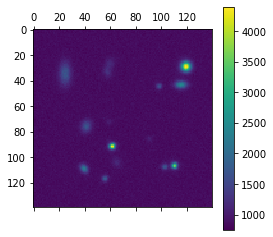

In [15]:
%matplotlib inline
plt.matshow(batch['images'][0, 0].cpu())
plt.colorbar()

# Train

In [16]:
sleep_net.train();

In [17]:
n_iter = 500

In [18]:
learning_rate = 1e-3
weight_decay = 1e-5
optimizer = optim.Adam([
                    {'params': sleep_net.parameters(),
                    'lr': learning_rate}],
                    weight_decay = weight_decay)


In [19]:
t0 = time.time()

for i in range(n_iter): 
        
    batch = simulated_dataset.sample_batch()
    
    optimizer.zero_grad()
    loss = sleep_net.get_detection_loss(batch)[0]
    
    if torch.isnan(loss): 
        break
    
    loss.backward()
    optimizer.step()

    if i % 50 == 0: 
        elapsed = time.time() - t0
        print('iter: [{}]; loss: {:0.4f}; elapsed: {:0.2f}secs'.format(i, loss, elapsed))
        t0 = time.time()

iter: [0]; loss: 3.4056; elapsed: 0.21secs
iter: [50]; loss: 0.1834; elapsed: 8.50secs
iter: [100]; loss: 0.0668; elapsed: 8.55secs
iter: [150]; loss: -0.0317; elapsed: 8.59secs
iter: [200]; loss: -0.1110; elapsed: 8.62secs
iter: [250]; loss: 0.0680; elapsed: 8.63secs
iter: [300]; loss: -0.0724; elapsed: 8.65secs
iter: [350]; loss: -0.1588; elapsed: 8.66secs
iter: [400]; loss: -0.1944; elapsed: 8.67secs
iter: [450]; loss: -0.1537; elapsed: 8.66secs


# Evaluate

In [20]:
sleep_net.eval();

In [21]:
loss = sleep_net.get_detection_loss(batch)[0]
print(loss)

tensor(-0.0039, device='cuda:4', grad_fn=<MeanBackward0>)


### draw fresh batch

In [22]:
batch = simulated_dataset.sample_batch()

### get estimates

In [23]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(batch['images'])
    
    _true_tile_dict = dict(locs = batch['locs'],
                           n_sources = batch['n_sources'],
                           galaxy_bool = batch['galaxy_bool'])
    
    true_params = encoder.get_full_params(_true_tile_dict, slen)
    est_params = encoder.get_full_params(tile_est, slen)

In [24]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * slen + border_padding
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze().cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

### Plot

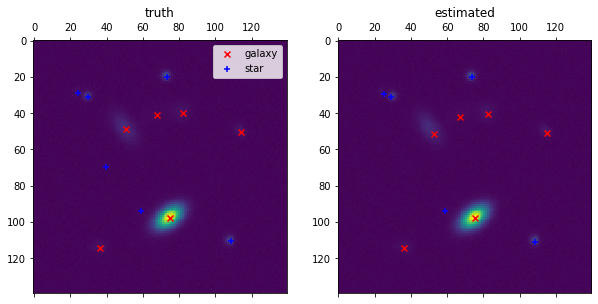

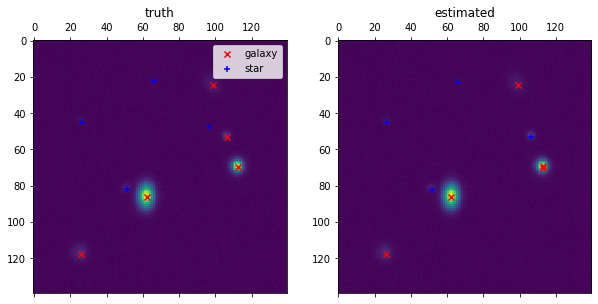

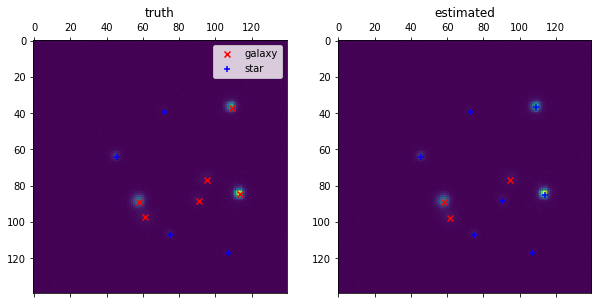

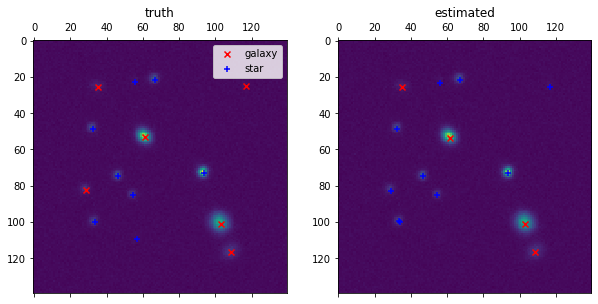

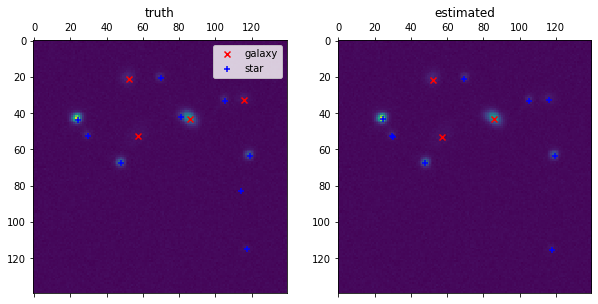

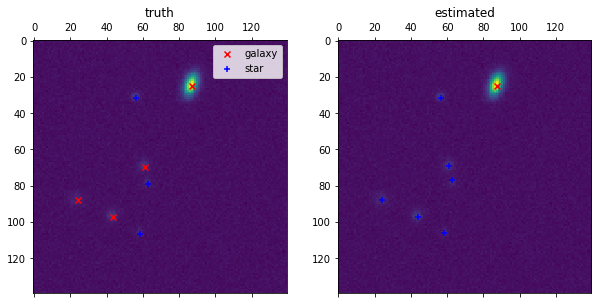

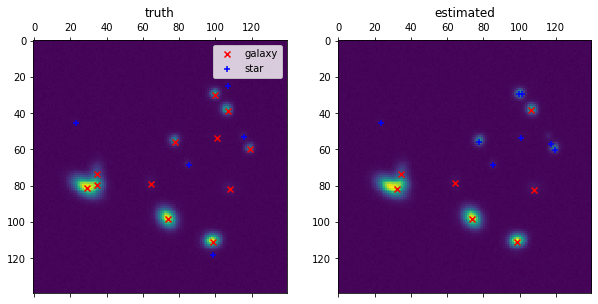

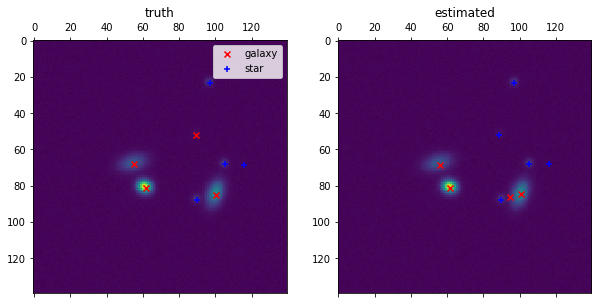

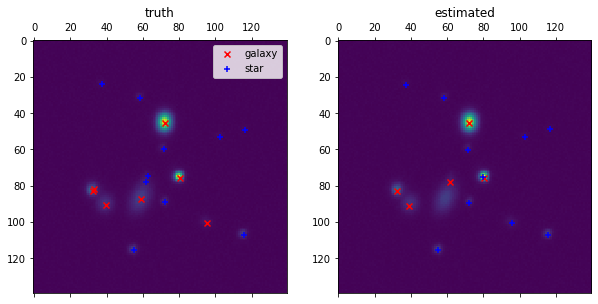

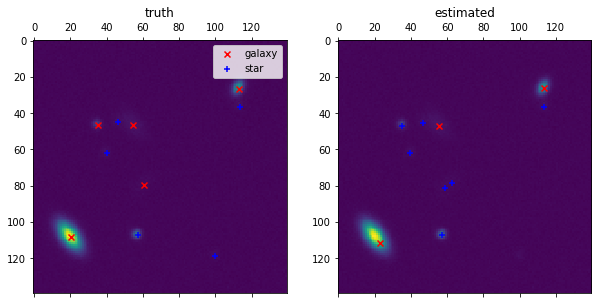

In [25]:
for indx in range(batchsize): 

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    for i in range(2): 
        axes[i].matshow(batch['images'][indx, 0].cpu())


    axes[0].set_title('truth')
    plot_params(true_params, indx, axes[0])
    axes[0].legend()

    axes[1].set_title('estimated')
    plot_params(est_params, indx, axes[1])

In [26]:
torch.save(sleep_net.image_encoder.state_dict(), './sleepnet')